In [7]:
# def dist(a, b, weights=None):
#     if weights is None:
#         weights = [1 for x in a]
    
#     dist = 0

#     for i in range(len(a)):
#         dist += weights[i] * ((a[i] - b[i])**2)**.5

#     return dist

def dist(a, b):
    return ((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)**.5

In [70]:
from scipy.optimize import NonlinearConstraint

def dynamics(state, inputs):
    """
    Simple kinematic bicycle model for dynamics simulation.
    
    Args:
    - state (array): Current state [x, y, theta, velocity].
    - inputs (array): Control inputs [angle, velocity].
    
    Returns:
    - next_state (array): Next state [x, y, theta, velocity].
    """
    x, y, theta, velocity = state
    angle, v = inputs
    
    L = 1.0  # Length of the vehicle
    
    x_dot = velocity * np.cos(theta)
    y_dot = velocity * np.sin(theta)
    theta_dot = velocity * np.tan(angle) / L
    velocity_dot = 0.0
    
    next_state = np.array([
        x + x_dot * dT,
        y + y_dot * dT,
        theta + theta_dot * dT,
        velocity + velocity_dot * dT
    ])
    
    return next_state

def final_state_cost(state):
    global goal_state

    # x_dist = dist(state, goal_state)
    
    x_dist = (state[0] - goal_state[0]) ** 2
    y_dist = (state[1] - goal_state[1]) ** 2
    vx_dist = (state[2] - goal_state[2]) ** 2
    vy_dist = (state[3] - goal_state[3]) ** 2

    return x_dist + y_dist + vx_dist + vy_dist
    # return 50**.5 * dist(state, goal_state)

def state_cost(state):
    global obstacles

    cost = 0

    if state[2] > 10 or state[2] < 0:
        cost += 100

    if state[3] > 10 or state[3] < 0:
        cost += 100

    for obstacle in obstacles:
        if dist(state, obstacle) <= obstacle[2]:
            cost += 100
            # return (obstacle[2]/dist(state, obstacle)) * 100

    return cost

def constraint_function(actions):
    global initial_state
    global dT
    state = initial_state
    actions = np.reshape(actions, (-1, 2))
    
    cost = 0.0

    for action in actions:
        cost += state_cost(state)
        state = dynamics(state, action, dT)

    cost += final_state_cost(state) + state_cost(state)

    return cost

constraint = NonlinearConstraint(constraint_function, lb=0, ub=0)

In [111]:
import numpy as np
from scipy.optimize import minimize

def dynamics(state, action, dT):
    x, y, vel_x, vel_y = state
    a_x, a_y = action

    vel_x += a_x * dT
    vel_y += a_y * dT
    x += vel_x * dT
    y += vel_y * dT

    return np.array( [ x, y, vel_x, vel_y ] )

def cost_function(actions):
    """
    Cost function to be minimized. 
    
    Args:
    - inputs (array): Control inputs [angle, velocity].
    
    Returns:
    - cost (float): Cost associated with the inputs.
    """
    # global initial_state
    # global dT
    # state = initial_state
    # actions = np.reshape(actions, (-1, 2))
    
    # cost = 0.0

    # for action in actions:
    #     cost += state_cost(state)
    #     state = dynamics(state, action, dT)

    # cost += final_state_cost(state) + state_cost(state)

    return 0

    # return cost

def calculate_optimal_input(goal_state, initial_guess, N, dT):
    # N actions
    # N+1 states
    actions = np.array( [initial_guess for i in range(N)] )
    actions = actions.flatten()
    
    # Bounds for angle and velocity
    bounds = [ (-20.0, 20.0) for i in range(N * 2) ]
    
    # Minimize the cost function
    result = minimize(cost_function, actions, constraints=constraint, bounds=bounds)
    
    optimal_inputs = result.x
    return optimal_inputs

# Example usage:
initial_state = np.array([0.0, 0.0, 0.0, 0.0])  # [x, y, theta, velocity]
goal_state = np.array([4.0, 7.0, 0.0, 0.0])

obstacles = [ (2, 2, 1), (4, 4, 2), (4, 9, .5)] # Obstacle at 6,6 with radius 1
# obstacles = []

N = 20  # Number of timesteps
dT = 0.1  # Time step size

initial_guess = [0, 0] # x_vel, y_vel

optimal_inputs = calculate_optimal_input(goal_state, initial_guess, N, dT)
print("Optimal inputs:", optimal_inputs)

actions = np.reshape(optimal_inputs, (-1, 2))
state = initial_state
for i in actions:
    state = dynamics(state, i, dT)

print(state)

Optimal inputs: [ 0.82162444  1.4378435   0.76876902  1.34534742  0.71591546  1.25285186
  0.6630632   1.1603582   0.61020874  1.06786533  0.55735482  0.97537164
  0.5045001   0.88287512  0.45164614  0.7903794   0.39879141  0.69788248
  0.34593684  0.60538929  0.29308221  0.5128958   0.2402284   0.42039956
  0.18737398  0.32790545  0.13452222  0.23541084  0.08166784  0.14291487
  0.02881306  0.05041843 -0.02404201 -0.04207519 -0.07689585 -0.13456977
 -0.12975069 -0.22706267 -0.1826054  -0.3195575 ]
[1.02245153 1.78928932 0.63902039 1.11828441]


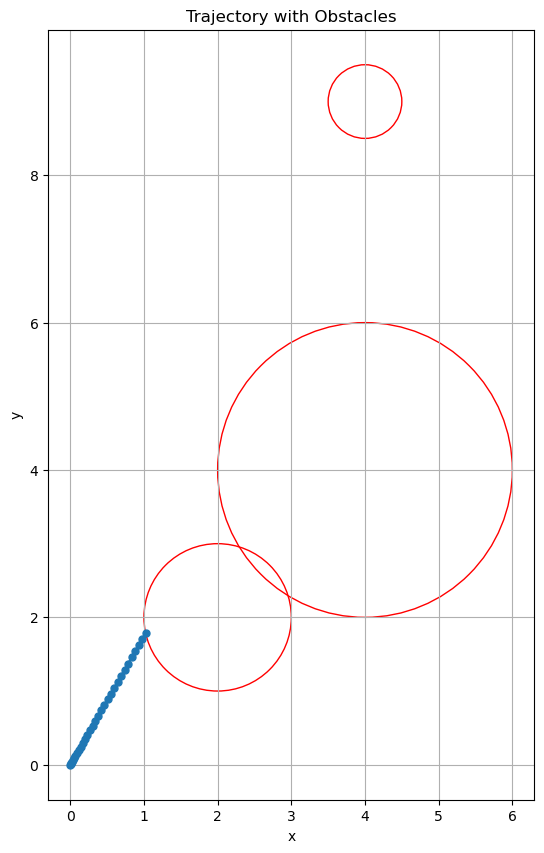

In [110]:
import matplotlib.pyplot as plt

# Calculate optimal inputs
optimal_actions = np.reshape(optimal_inputs, (-1, 2))
states = [initial_state]
for action in optimal_actions:
    states.append(dynamics(states[-1], action, dT))

# Extracting x, y, vx, vy from states
x = [state[0] for state in states]
y = [state[1] for state in states]
vx = [state[2] for state in states]
vy = [state[3] for state in states]

# Calculating ax and ay
ax = [(vx[i+1] - vx[i]) / dT for i in range(len(vx)-1)]
ay = [(vy[i+1] - vy[i]) / dT for i in range(len(vy)-1)]

# Plotting
plt.figure(figsize=(12, 10))

# Plotting trajectory on a coordinate grid
# plt.subplot(3, 1, 1)
plt.plot(x, y, marker='o', linestyle='-', markersize=5)
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', fill=False)
    plt.gca().add_patch(circle)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory with Obstacles')
plt.grid(True)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# plt.subplot(3, 1, 2)
# plt.plot(vx, label='vx')
# plt.plot(vy, label='vy')
# plt.legend()
# plt.grid(True)
# plt.title('Velocity')

# plt.subplot(3, 1, 3)
# plt.plot(ax, label='ax')
# plt.plot(ay, label='ay')
# plt.legend()
# plt.grid(True)
# plt.title('Acceleration')

# plt.tight_layout()
# plt.show()